<a href="https://colab.research.google.com/github/dalalelamine/shroom/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Task 2025 - Analysis Notebook

## Overview
This notebook provides a complete framework for working with the Mushroom Task 2025 dataset and participant kit. It includes data exploration, baseline model training, evaluation, and prediction generation.

## 🔑 Key Features:
- **Complete Setup Structure**: Creates necessary directories and handles dataset extraction.
- **Data Exploration**: Loads and analyzes JSONL files, examines language distributions, and visualizes text characteristics.
- **Format Validation**: Integrates the format checker to validate prediction files.
- **Baseline Model Integration**: Runs the baseline model training and inference using the provided scripts.
- **Evaluation Framework**: Analyzes predictions and calculates metrics.
- **Submission Pipeline**: Generates final predictions and validates them.

## ✅ What the Notebook Does:
- **Data Loading**: Automatically extracts uploaded ZIP files and explores the dataset structure.
- **Analysis & Visualization**: Creates charts showing language distributions and text characteristics.
- **Model Training**: Runs the baseline model for different languages using the participant kit.
- **Format Checking**: Validates prediction files using the provided format checker.
- **Results Analysis**: Loads and analyzes model predictions with metrics.
- **Final Submission**: Generates properly formatted prediction files.

## 🛠️ To Use This Notebook:
1. **Upload** your dataset ZIP files to the notebook environment.
2. **Update file paths** in the data loading section based on your dataset structure.
3. Ensure `format_checker.py` and `baseline_model.py` are in the same directory.
4. **Run cells sequentially** to complete the entire pipeline.

> 💡 The notebook is modular—run sections independently and customize parameters as needed. All outputs (models, predictions, visualizations) are saved in organized folders for easy access.


## Table of Contents
1. [Setup and Dependencies](#setup)
2. [Data Loading and Exploration](#data-loading)
3. [Format Checker Usage](#format-checker)
4. [Baseline Model Training](#baseline-training)
5. [Model Evaluation](#evaluation)
6. [Predictions and Submission](#predictions)

---

## 1. Setup and Dependencies {#setup}

In [1]:
!pip install jsonlines
# Import necessary libraries
import os
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import subprocess
import sys
from collections import Counter
import warnings

import json
import jsonlines
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


print("Environment setup complete!")

Environment setup complete!


In [2]:
# Create directory structure
directories = [
    'data',
    #'data/train',
    #'data/val',
    #'data/test',
    'results',
    'predictions',
    'visualizations'
]

for directory in directories:
    os.makedirs(directory, exist_ok=True)
    print(f"Created directory: {directory}")

Created directory: data
Created directory: results
Created directory: predictions
Created directory: visualizations


## 2. Data Loading and Exploration {#data-loading}


### 2.1 Extract Dataset Files


In [3]:
# Function to extract zip files
def extract_dataset(zip_path, extract_to):
    """Extract zip file to specified directory"""
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Successfully extracted {zip_path} to {extract_to}")
        return True
    except Exception as e:
        print(f"Error extracting {zip_path}: {str(e)}")
        return False

# Extract uploaded dataset files
# Note: Update these paths based on your uploaded files
dataset_files = [
 'train.zip',
'val.zip'  ,
 'test.zip',
 'test-unlabeled.zip',
 'sample.zip'
]

for zip_file in dataset_files:
    if os.path.exists(zip_file):
        # Determine extraction path based on filename
        extract_to = 'data'
        extract_dataset(zip_file, extract_to)

Successfully extracted val.zip to data
Successfully extracted test.zip to data


### 2.2 Data Structure Analysis


In [4]:
# Function to explore directory structure
def explore_directory(path, max_depth=3, current_depth=0):
    """Recursively explore directory structure"""
    items = []
    if current_depth >= max_depth:
        return items

    try:
        for item in sorted(os.listdir(path)):
            item_path = os.path.join(path, item)
            indent = "  " * current_depth
            if os.path.isdir(item_path):
                items.append(f"{indent}{item}/")
                items.extend(explore_directory(item_path, max_depth, current_depth + 1))
            else:
                size = os.path.getsize(item_path)
                items.append(f"{indent}{item} ({size} bytes)")
    except PermissionError:
        items.append(f"{indent}[Permission Denied]")

    return items

print("Dataset directory structure:")
print("\n".join(explore_directory("data")))

Dataset directory structure:
val/
  README-v2.md (4314 bytes)
  mushroom.ar-val.v2.jsonl (116223 bytes)
  mushroom.de-val.v2.jsonl (85925 bytes)
  mushroom.en-val.v2.jsonl (116770 bytes)
  mushroom.es-val.v2.jsonl (222117 bytes)
  mushroom.fi-val.v2.jsonl (98727 bytes)
  mushroom.fr-val.v2.jsonl (213801 bytes)
  mushroom.hi-val.v2.jsonl (147994 bytes)
  mushroom.it-val.v2.jsonl (72623 bytes)
  mushroom.sv-val.v2.jsonl (61875 bytes)
  mushroom.zh-val.v2.jsonl (563865 bytes)
  scripts/
    arabic/
    chinese/
    english/
    finnish/
    french/
    german/
    hindi/
    italian/
    spanish/
    swedish/


### 2.3 Load and Examine Data Files


In [5]:
def load_jsonl(file_path):
    """Load JSONL file and return list of dictionaries"""
    data = []
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                data.append(json.loads(line.strip()))
        return data
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")
        return []

# Function to examine data structure
def examine_data(data, dataset_name):
    """Examine and display data structure"""
    print(f"\n=== {dataset_name} Dataset Analysis ===")
    print(f"Number of samples: {len(data)}")

    if len(data) > 0:
        print(f"Keys in first sample: {list(data[0].keys())}")
        print(f"First sample:")
        for key, value in data[0].items():
            if isinstance(value, str) and len(value) > 100:
                print(f"  {key}: {value[:100]}...")
            else:
                print(f"  {key}: {value}")

    return data

# Load datasets (update paths as needed)
train_data = []
val_data = []
test_data = []

# Look for common JSONL files
for root, dirs, files in os.walk("data"):
    for file in files:
        if file.endswith('.jsonl'):
            file_path = os.path.join(root, file)
            data = load_jsonl(file_path)

            if 'train' in file.lower() or 'train' in root:
                train_data.extend(data)
                examine_data(data, f"Training ({file})")
            elif 'val' in file.lower() or 'val' in root:
                val_data.extend(data)
                examine_data(data, f"Validation ({file})")
            elif 'test' in file.lower() or 'test' in root:
                test_data.extend(data)
                examine_data(data, f"Test ({file})")


=== Validation (mushroom.en-val.v2.jsonl) Dataset Analysis ===
Number of samples: 50
Keys in first sample: ['id', 'lang', 'model_input', 'model_output_text', 'model_id', 'soft_labels', 'hard_labels', 'model_output_logits', 'model_output_tokens']
First sample:
  id: val-en-1
  lang: EN
  model_input: What did Petra van Staveren win a gold medal for?
  model_output_text: Petra van Stoveren won a silver medal in the 2008 Summer Olympics in Beijing, China.
  model_id: tiiuae/falcon-7b-instruct
  soft_labels: [{'start': 10, 'prob': 0.2, 'end': 12}, {'start': 12, 'prob': 0.3, 'end': 13}, {'start': 13, 'prob': 0.2, 'end': 18}, {'start': 25, 'prob': 0.9, 'end': 31}, {'start': 31, 'prob': 0.1, 'end': 37}, {'start': 45, 'prob': 1.0, 'end': 49}, {'start': 49, 'prob': 0.3, 'end': 65}, {'start': 65, 'prob': 0.2, 'end': 69}, {'start': 69, 'prob': 0.9, 'end': 83}]
  hard_labels: [[25, 31], [45, 49], [69, 83]]
  model_output_logits: [-5.5669536591, -11.90533638, -13.0743436813, -9.9514026642, -8.8359

### 2.4 Data Statistics and Visualization


In [6]:
# Function to analyze language distribution
def analyze_language_distribution(data, dataset_name):
    """Analyze and visualize language distribution"""
    if not data:
        print(f"No data available for {dataset_name}")
        return

    # Extract languages
    languages = [item.get('language', 'unknown') for item in data]
    lang_counts = Counter(languages)

    print(f"\n=== {dataset_name} Language Distribution ===")
    for lang, count in lang_counts.most_common():
        print(f"{lang}: {count} samples")

    # Create visualization
    if len(lang_counts) > 1:
        plt.figure(figsize=(10, 6))
        langs, counts = zip(*lang_counts.most_common())
        plt.bar(langs, counts)
        plt.title(f'{dataset_name} - Language Distribution')
        plt.xlabel('Language')
        plt.ylabel('Number of Samples')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f'visualizations/{dataset_name.lower()}_lang_dist.png', dpi=300, bbox_inches='tight')
        plt.show()

    return lang_counts

# Analyze all datasets
train_lang_dist = analyze_language_distribution(train_data, "Training")
val_lang_dist = analyze_language_distribution(val_data, "Validation")
test_lang_dist = analyze_language_distribution(test_data, "Test")

No data available for Training

=== Validation Language Distribution ===
unknown: 499 samples
No data available for Test



=== Validation Text Characteristics ===
Average text length (chars): 52.70
Average word count: 8.36
Min text length: 10
Max text length: 135


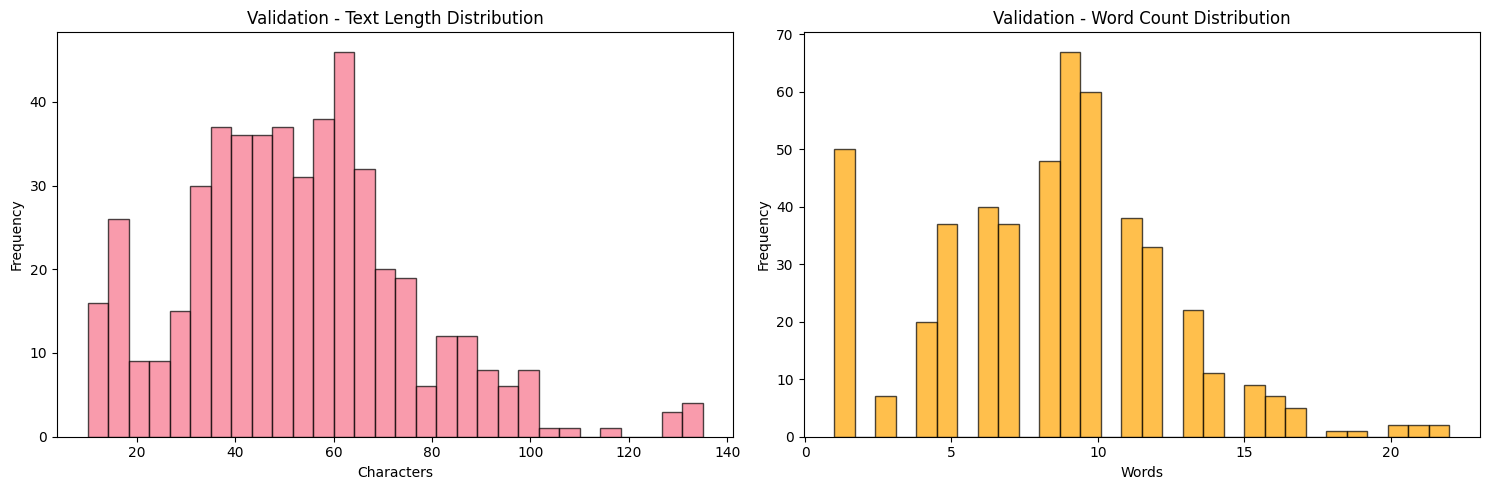

In [7]:
def analyze_text_characteristics(data, dataset_name, text_field='model_input'):
    """Analyze text characteristics like length, vocabulary, etc."""
    if not data:
        return

    texts = [item.get(text_field, '') for item in data]
    text_lengths = [len(text) for text in texts]
    word_counts = [len(text.split()) for text in texts]

    print(f"\n=== {dataset_name} Text Characteristics ===")
    print(f"Average text length (chars): {np.mean(text_lengths):.2f}")
    print(f"Average word count: {np.mean(word_counts):.2f}")
    print(f"Min text length: {min(text_lengths)}")
    print(f"Max text length: {max(text_lengths)}")

    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Text length distribution
    axes[0].hist(text_lengths, bins=30, alpha=0.7, edgecolor='black')
    axes[0].set_title(f'{dataset_name} - Text Length Distribution')
    axes[0].set_xlabel('Characters')
    axes[0].set_ylabel('Frequency')

    # Word count distribution
    axes[1].hist(word_counts, bins=30, alpha=0.7, edgecolor='black', color='orange')
    axes[1].set_title(f'{dataset_name} - Word Count Distribution')
    axes[1].set_xlabel('Words')
    axes[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(f'visualizations/{dataset_name.lower()}_text_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Analyze text characteristics
analyze_text_characteristics(train_data, "Training")
analyze_text_characteristics(val_data, "Validation")

## 3. Format Checker Usage {#format-checker}

### 3.1 Create Sample Predictions

In [8]:
# Create sample predictions for format checking
def create_sample_predictions(data, output_file):
    """Create sample predictions in the required format"""
    predictions = []

    for item in data:
        # Create dummy predictions - replace with actual model predictions
        pred = {
            'id': item.get('id', ''),
            'prediction': 0.5,  # Dummy soft prediction
            'hard_prediction': 1  # Dummy hard prediction
        }
        predictions.append(pred)

    # Write predictions to JSONL file
    with open(output_file, 'w') as f:
        for pred in predictions:
            f.write(json.dumps(pred) + '\n')

    print(f"Sample predictions saved to {output_file}")
    return output_file

# Create sample predictions for testing format checker
if test_data:
    sample_pred_file = create_sample_predictions(test_data, 'predictions/sample_predictions.jsonl')


### 3.2 Run Format Checker


In [ ]:
def run_format_checker(test_data_path, prediction_file):
    """Run the format checker script"""
    try:
        cmd = [sys.executable, 'format_checker.py', test_data_path, prediction_file]
        result = subprocess.run(cmd, capture_output=True, text=True, cwd='.')

        print("=== Format Checker Output ===")
        print("STDOUT:", result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
        print("Return code:", result.returncode)

        return result.returncode == 0
    except Exception as e:
        print(f"Error running format checker: {str(e)}")
        return False

# Run format checker if files exist
if os.path.exists('format_checker.py') and os.path.exists('data/sample/sample_set.v1.json'):
    test_path = 'data/test'  # Update this path as needed
    success = run_format_checker(test_path, 'data/sample/sample_set.v1.json')
    print(f"Format check {'passed' if success else 'failed'}")
else:
    print("Format checker or prediction file not found. Please ensure format_checker.py is available.")

=== Format Checker Output ===
STDOUT: 
STDERR: Traceback (most recent call last):
  File "/content/format_checker.py", line 89, in <module>
    main(args.jsonl_files, args.path_to_unlabeled_test_files)
  File "/content/format_checker.py", line 61, in main
    raise RuntimeError(f'All files should be in the .jsonl format, but you submitted {fname.name}.')
RuntimeError: All files should be in the .jsonl format, but you submitted sample_set.v1.json.

Return code: 1
Format check failed


## 4. Baseline Model Training {#baseline-training}


### 4.1 Training Configuration


In [8]:
# Define training configurations for different languages
#languages_to_test = ['ar','de','en','es','fi','fr','hi','it','sv','zh']  # Update based on available languages
languages_to_test = ['en']
training_configs = {
    'output_path': './results',
    'data_path': './data/val',  # Update path as needed
    'epochs': 20,
    'batch_size': 16,
    'learning_rate': 2e-5
}

print("Training Configuration:")
for key, value in training_configs.items():
    print(f"  {key}: {value}")

Training Configuration:
  output_path: ./results
  data_path: ./data/val
  epochs: 20
  batch_size: 16
  learning_rate: 2e-05


In [9]:
# Verify the data path before starting training
def verify_data_setup():
    """Verify that the data path and files exist"""
    data_path = Path(training_configs['data_path'])

    print("=== Data Setup Verification ===")
    print(f"Working directory: {os.getcwd()}")
    print(f"Data path: {data_path.absolute()}")
    print(f"Data path exists: {data_path.exists()}")

    if not data_path.exists():
        print("❌ Data path does not exist!")

        # Check alternative paths
        alternative_paths = [
            Path('/content/data/val'),
            Path('data/train'),
            Path('data/val'),
            Path('./data/train'),
            Path('./data/val')
        ]

        print("\nChecking alternative paths:")
        for alt_path in alternative_paths:
            if alt_path.exists():
                files = list(alt_path.glob("*.jsonl"))
                print(f"✓ Found: {alt_path.absolute()} ({len(files)} JSONL files)")
                if len(files) > 0:
                    print(f"  Suggested data_path: '{alt_path}'")
            else:
                print(f"✗ Not found: {alt_path.absolute()}")

        return False

    # Check for expected training files
    jsonl_files = list(data_path.glob("*.jsonl"))
    print(f"\nFound {len(jsonl_files)} JSONL files:")

    # Group files by language and split
    files_by_lang = {}
    for file in jsonl_files:
        # Parse filename: mushroom.{lang}-{split}.v1.jsonl
        parts = file.stem.split('.')
        if len(parts) >= 2:
            lang_split = parts[1].split('-')
            if len(lang_split) >= 2:
                lang = lang_split[0]
                split = lang_split[1]

                if lang not in files_by_lang:
                    files_by_lang[lang] = {}
                files_by_lang[lang][split] = file.name

    print("\nFiles by language:")
    for lang in sorted(files_by_lang.keys()):
        splits = files_by_lang[lang]
        print(f"  {lang}: {list(splits.keys())}")

    # Check if we have files for our test languages
    missing_languages = []
    for lang in languages_to_test:
        if lang not in files_by_lang:
            missing_languages.append(lang)
        elif  'val' not in files_by_lang[lang]:
            print(f"⚠ Warning: {lang} missing training or validation split")

    if missing_languages:
        print(f"❌ Missing data for languages: {missing_languages}")
        return False

    print("✅ Data setup looks good!")
    return True
verify_data_setup()

=== Data Setup Verification ===
Working directory: /content
Data path: /content/data/val
Data path exists: True

Found 10 JSONL files:

Files by language:
  ar: ['val']
  de: ['val']
  en: ['val']
  es: ['val']
  fi: ['val']
  fr: ['val']
  hi: ['val']
  it: ['val']
  sv: ['val']
  zh: ['val']
✅ Data setup looks good!


True

In [10]:
!pwd

import transformers
print(transformers.__version__)

!pip install seqeval

/content
4.53.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=4589c19769c4f75cff5aaf6f8a33423d3c59a9a1279837fe404ab4dc9ff1fbca
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


### 4.2 Run Baseline Training


In [11]:
# Function to run baseline model training
# Function to run baseline model training
def run_baseline_training(test_lang, config):
    """Run baseline model training excluding one test language"""
    try:
        # Based on the error, the baseline_model.py script only accepts:
        # --mode, --data_path, --model_checkpoint, --test_lang
        cmd = [
            sys.executable, 'baseline_model.py',
            '--mode', 'train',
            '--data_path', config['data_path'],
            '--test_lang', test_lang
        ]

        print(f"\n=== Training Model (excluding {test_lang}) ===")
        print(f"Command: {' '.join(cmd)}")

        result = subprocess.run(cmd, capture_output=True, text=True, cwd='.')

        print("Training Output:")
        print(result.stdout)
        if result.stderr:
            print("Training Errors:")
            print(result.stderr)

        return result.returncode == 0, result
    except Exception as e:
        print(f"Error running training: {str(e)}")
        return False, None

# Run training for each language
training_results = {}

if os.path.exists('baseline_model.py'):
    for lang in languages_to_test:
        success, result = run_baseline_training(lang, training_configs)
        training_results[lang] = {
            'success': success,
            'result': result
        }

        if success:
            print(f"✓ Training completed for {lang}")
        else:
            print(f"✗ Training failed for {lang}")
else:
    print("baseline_model.py not found. Please ensure the script is available.")


=== Training Model (excluding en) ===
Command: /usr/bin/python3 baseline_model.py --mode train --data_path ./data/val --test_lang en
Training Output:
tokenized_datasets:
 DatasetDict({
    train: Dataset({
        features: ['id', 'lang', 'model_input', 'model_output_text', 'model_id', 'soft_labels', 'hard_labels', 'model_output_tokens', 'model_output_logits', 'input_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 449
    })
    validation: Dataset({
        features: ['id', 'lang', 'model_input', 'model_output_text', 'model_id', 'soft_labels', 'hard_labels', 'model_output_logits', 'model_output_tokens', 'input_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 50
    })
})
{'train_runtime': 259.7566, 'train_samples_per_second': 8.643, 'train_steps_per_second': 0.558, 'train_loss': 0.28659823187466327, 'epoch': 5.0}
Model trained and evaluated successfully. Model checkpoint saved in ./results
wandb: 
wandb: 🚀 View run ./results at: https://wa

### 4.3 Monitor Training Progress


In [13]:
import os

import os

def parse_training_logs(output_path):
    """Parse training logs and identify checkpoint directories"""
    log_files = []
    model_dirs = []

    # Search for logs and checkpoint directories
    for root, dirs, files in os.walk(output_path):
        for file in files:
            file_lower = file.lower()
            file_path = os.path.join(root, file)

            # Collect training logs
            if file.endswith('.log') or 'train' in file_lower:
                log_files.append(file_path)

        # Detect checkpoint directories (must contain model files)
        if any(f for f in files if f in ["pytorch_model.bin", "model.safetensors"]):
            model_dirs.append(root)

    print(f"Found {len(log_files)} log files and {len(model_dirs)} model directories.")
    return model_dirs, log_files


# Example usage
output_files, log_files = parse_training_logs(training_configs['output_path'])
print(f"Training log files:\n{log_files}")
print(f"Training output files:\n{output_files}")


Found 2 log files and 1 model directories.
Training log files:
['./results/checkpoint-145/training_args.bin', './results/checkpoint-145/trainer_state.json']
Training output files:
['./results/checkpoint-145']


## 5. Model Evaluation {#evaluation}


### 5.1 Run Model Inference


In [24]:
# Function to run model inference
def run_baseline_inference(test_lang, model_checkpoint=None, config=None):
    """Run baseline model inference"""
    try:
        cmd = [
            sys.executable, 'baseline_model.py',
            '--mode', 'test',
            '--data_path', 'data/test',
            '--test_lang', test_lang
        ]

        # Only add model_checkpoint if provided and exists
        if model_checkpoint and os.path.exists(model_checkpoint):
            cmd.extend(['--model_checkpoint', model_checkpoint])

        print(f"\n=== Running Inference for {test_lang} ===")
        print(f"Command: {' '.join(cmd)}")

        result = subprocess.run(cmd, capture_output=True, text=True, cwd='.')

        print("Inference Output:")
        print(result.stdout)
        if result.stderr:
            print("Inference Errors:")
            print(result.stderr)

        return result.returncode == 0, result
    except Exception as e:
        print(f"Error running inference: {str(e)}")
        return False, None

# Run inference for each trained model
inference_results = {}

if os.path.exists('baseline_model.py'):
    # First, let's see what checkpoint files were created
    checkpoint_files = []
    for file in output_files:
        if 'checkpoint' in file.lower() or 'model' in file.lower():
            checkpoint_files.append(file)

    print(f"Found checkpoint files: {checkpoint_files}")

    for lang in languages_to_test:
        print(f"\n" + "="*50)
        print(f"INFERENCE FOR LANGUAGE: {lang}")
        print("="*50)

        # Try to find the appropriate checkpoint
        checkpoint_path = None
        for checkpoint in checkpoint_files:
            # Look for checkpoint that might correspond to this language
            if lang in checkpoint or 'checkpoint-20' in checkpoint:
                checkpoint_path = checkpoint
                break

        if not checkpoint_path and checkpoint_files:
            # Use the first available checkpoint
            checkpoint_path = checkpoint_files[0]

        print(f"Using checkpoint: {checkpoint_path}")

        success, result = run_baseline_inference(lang, checkpoint_path, training_configs)
        inference_results[lang] = {
            'success': success,
            'result': result,
            'checkpoint': checkpoint_path
        }

        if success:
            print(f"✓ Inference completed for {lang}")
        else:
            print(f"✗ Inference failed for {lang}")
else:
    print("baseline_model.py not found.")

Found checkpoint files: ['./results/checkpoint-145']

INFERENCE FOR LANGUAGE: en
Using checkpoint: ./results/checkpoint-145

=== Running Inference for en ===
Command: /usr/bin/python3 baseline_model.py --mode test --data_path data/test --test_lang en --model_checkpoint ./results/checkpoint-145
Inference Output:
Test model: ./results/checkpoint-145
Labels saved to en-hard_labels.json and en-soft_labels.json
Prediction file saved to en-pred.jsonl

Inference Errors:
2025-07-24 20:53:28.424694: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753390408.444843   20062 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753390408.451447   20062 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when o

### 5.2 Load and Analyze Predictions


In [25]:
# Function to load and analyze model predictions
def load_and_analyze_predictions(results_path):
    """Load and analyze model predictions"""
    prediction_files = []

    # Look for prediction files
    #if os.path.exists(results_path):
    #    for root, dirs, files in os.walk(results_path):
    #        for file in files:
    #            if file.endswith('.json') and ('prediction' in file.lower() or 'pred' in file.lower()):
    #                prediction_files.append(os.path.join(root, file))
    prediction_files.append(os.path.join(results_path, "en-soft_labels.json"))
    #prediction_files.append(os.path.join(results_path, "en-pred.jsonl"))
    prediction_files.append(os.path.join(results_path, "en-hard_labels.json"))

    print(f"Found {len(prediction_files)} prediction files")

    predictions_data = {}

    for pred_file in prediction_files:
        try:
            with open(pred_file, 'r') as f:
                data = json.load(f)
            predictions_data[pred_file] = data
            print(f"Loaded predictions from {pred_file}")
        except Exception as e:
            print(f"Error loading {pred_file}: {str(e)}")

    return predictions_data

# Load prediction results
predictions_data = load_and_analyze_predictions(training_configs['output_path'])
print(predictions_data)

Found 2 prediction files
Loaded predictions from ./results/en-soft_labels.json
Loaded predictions from ./results/en-hard_labels.json
{'./results/en-soft_labels.json': {'tst-en-1': [{'start': 0, 'end': 0, 'prob': 0.37305596470832825}, {'start': 1, 'end': 3, 'prob': 0.3730422258377075}, {'start': 3, 'end': 4, 'prob': 0.37298357486724854}, {'start': 5, 'end': 10, 'prob': 0.37304407358169556}, {'start': 10, 'end': 11, 'prob': 0.40453261137008667}, {'start': 12, 'end': 14, 'prob': 0.3730328679084778}, {'start': 14, 'end': 17, 'prob': 0.37296628952026367}, {'start': 17, 'end': 19, 'prob': 0.372931569814682}, {'start': 20, 'end': 23, 'prob': 0.37295934557914734}, {'start': 24, 'end': 27, 'prob': 0.4421437084674835}, {'start': 28, 'end': 30, 'prob': 0.3718242645263672}, {'start': 31, 'end': 34, 'prob': 0.37305453419685364}, {'start': 35, 'end': 37, 'prob': 0.37303626537323}, {'start': 38, 'end': 41, 'prob': 0.3870743215084076}, {'start': 42, 'end': 46, 'prob': 0.3730544149875641}, {'start': 47

### 5.3 Evaluation Metrics


In [26]:
import numpy as np
from collections import Counter
import os

def calculate_soft_metrics(entries):
    """Compute soft label statistics (probability-based)"""
    probs = [e.get("prob") for e in entries if "prob" in e]
    probs = [p for p in probs if p is not None]

    return {
        'num_predictions': len(probs),
        'soft_pred_mean': np.mean(probs) if probs else 0,
        'soft_pred_std': np.std(probs) if probs else 0,
    }

def calculate_hard_metrics(entries):
    """Compute hard label class distribution (0/1)"""
    labels = [int(e) for e in entries if isinstance(e, int) or (isinstance(e, str) and e.isdigit())]
    return {
        'num_predictions': len(labels),
        'hard_pred_distribution': dict(Counter(labels)) if labels else {}
    }

# Loop over all prediction files
for pred_file, contents in predictions_data.items():
    print(f"\n=== Metrics for {os.path.basename(pred_file)} ===")

    for key, entry_list in contents.items():
        print(f"\nSubset: {key}")

        # Detect file type by filename
        if 'soft' in pred_file.lower():
            metrics = calculate_soft_metrics(entry_list)
        elif 'hard' in pred_file.lower():
            metrics = calculate_hard_metrics(entry_list)
        else:
            print("⚠️ Unknown prediction type — skipping")
            continue

        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value}")




=== Metrics for en-soft_labels.json ===

Subset: tst-en-1
num_predictions: 345
soft_pred_mean: 0.37369195145109424
soft_pred_std: 0.004928338466532664

Subset: tst-en-2
num_predictions: 345
soft_pred_mean: 0.37569222078807113
soft_pred_std: 0.007075021592107421

Subset: tst-en-3
num_predictions: 345
soft_pred_mean: 0.3617649913698003
soft_pred_std: 0.01286360476427589

Subset: tst-en-4
num_predictions: 345
soft_pred_mean: 0.3466880264489547
soft_pred_std: 0.0189534788769261

Subset: tst-en-5
num_predictions: 345
soft_pred_mean: 0.26616392761900803
soft_pred_std: 0.0514095436570804

Subset: tst-en-6
num_predictions: 345
soft_pred_mean: 0.3529388013957203
soft_pred_std: 0.013601839344755815

Subset: tst-en-7
num_predictions: 345
soft_pred_mean: 0.32040674392727836
soft_pred_std: 0.02613757974747618

Subset: tst-en-8
num_predictions: 345
soft_pred_mean: 0.3663718902546427
soft_pred_std: 0.006723110248668709

Subset: tst-en-9
num_predictions: 345
soft_pred_mean: 0.35064513389615043
soft_p


TEST THIS to get baseline-model metrics

This evaluation script provides comprehensive metrics for your Mu-shroom shared task results. Here's what it does:
Key Features:

Loads both files correctly:

Ground truth from en-hard_labels.json
Predictions from en-pred.jsonl (extracts hard_labels)


Two evaluation approaches:

Span-level: Exact span matching with precision, recall, F1
Token-level: Converts spans to binary labels for token classification metrics


Comprehensive metrics:

Exact match accuracy (percentage of samples with perfect span matching)
Span precision, recall, and F1-score
Token-level accuracy, precision, recall, and F1
Detailed counts (TP, FP, FN)


Sample analysis: Shows individual sample comparisons to help debug

Required dependencies:
bashpip install scikit-learn jsonlines numpy
Usage:
Just run the script in the same directory as your files:
bashpython evaluation_script.py
The script will automatically match samples using their IDs and compute all relevant metrics. It handles missing predictions gracefully and provides detailed output to help you understand your model's performance.
The span-level evaluation is probably most important for the Mu-shroom task since it evaluates exact boundary detection, while token-level gives you additional insights into per-token classification performance.

In [27]:
!pip install jsonlines

In [30]:
import json
import jsonlines
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

def load_test_labels(filepath):
    """Load test labels from JSONL file containing ground truth."""
    labels = {}
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            labels[obj['id']] = obj['hard_labels']
    return labels

def load_predictions(filepath):
    """Load predictions from JSONL file."""
    predictions = {}
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            # Extract hard_labels from predictions
            predictions[obj['id']] = obj['hard_labels']
    return predictions

def spans_to_binary_labels(spans, max_length=None):
    """Convert span annotations to binary sequence labels."""
    if max_length is None:
        # Find the maximum end position across all spans
        max_length = max([end for start, end in spans]) if spans else 0

    labels = [0] * max_length
    for start, end in spans:
        for i in range(start, min(end, max_length)):
            labels[i] = 1
    return labels

def evaluate_spans_exact_match(ground_truth, predictions):
    """Evaluate using exact span matching."""
    total_samples = 0
    correct_samples = 0

    all_gt_spans = []
    all_pred_spans = []

    for id_ in ground_truth:
        if id_ in predictions:
            total_samples += 1
            gt_spans = set(tuple(span) for span in ground_truth[id_])
            pred_spans = set(tuple(span) for span in predictions[id_])

            # Exact match for this sample
            if gt_spans == pred_spans:
                correct_samples += 1

            # Collect all spans for overall metrics
            all_gt_spans.extend(gt_spans)
            all_pred_spans.extend(pred_spans)

    # Calculate overall span-level metrics
    all_gt_spans_set = set(all_gt_spans)
    all_pred_spans_set = set(all_pred_spans)

    tp = len(all_gt_spans_set & all_pred_spans_set)
    fp = len(all_pred_spans_set - all_gt_spans_set)
    fn = len(all_gt_spans_set - all_pred_spans_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    exact_match_accuracy = correct_samples / total_samples if total_samples > 0 else 0

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'span_precision': precision,
        'span_recall': recall,
        'span_f1': f1,
        'total_samples': total_samples,
        'correct_samples': correct_samples,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }

def evaluate_token_level(ground_truth, predictions):
    """Evaluate at token level using binary classification metrics."""
    all_gt_labels = []
    all_pred_labels = []

    for id_ in ground_truth:
        if id_ in predictions:
            # Find maximum length needed
            gt_spans = ground_truth[id_]
            pred_spans = predictions[id_]

            max_len = 0
            if gt_spans:
                max_len = max(max_len, max([end for start, end in gt_spans]))
            if pred_spans:
                max_len = max(max_len, max([end for start, end in pred_spans]))

            if max_len > 0:
                gt_labels = spans_to_binary_labels(gt_spans, max_len)
                pred_labels = spans_to_binary_labels(pred_spans, max_len)

                all_gt_labels.extend(gt_labels)
                all_pred_labels.extend(pred_labels)

    if not all_gt_labels:
        return None

    # Calculate metrics
    accuracy = accuracy_score(all_gt_labels, all_pred_labels)
    precision, recall, f1, support = precision_recall_fscore_support(
        all_gt_labels, all_pred_labels, average='binary', pos_label=1
    )

    return {
        'token_accuracy': accuracy,
        'token_precision': precision,
        'token_recall': recall,
        'token_f1': f1,
        'total_tokens': len(all_gt_labels),
        'positive_tokens': sum(all_gt_labels)
    }

def print_evaluation_results(span_results, token_results):
    """Print formatted evaluation results."""
    print("=" * 60)
    print("MU-SHROOM EVALUATION RESULTS")
    print("=" * 60)

    print("\n--- SPAN-LEVEL EVALUATION ---")
    print(f"Exact Match Accuracy: {span_results['exact_match_accuracy']:.4f}")
    print(f"Span Precision:       {span_results['span_precision']:.4f}")
    print(f"Span Recall:          {span_results['span_recall']:.4f}")
    print(f"Span F1-Score:        {span_results['span_f1']:.4f}")
    print(f"Total Samples:        {span_results['total_samples']}")
    print(f"Correct Samples:      {span_results['correct_samples']}")
    print(f"True Positives:       {span_results['true_positives']}")
    print(f"False Positives:      {span_results['false_positives']}")
    print(f"False Negatives:      {span_results['false_negatives']}")

    if token_results:
        print("\n--- TOKEN-LEVEL EVALUATION ---")
        print(f"Token Accuracy:       {token_results['token_accuracy']:.4f}")
        print(f"Token Precision:      {token_results['token_precision']:.4f}")
        print(f"Token Recall:         {token_results['token_recall']:.4f}")
        print(f"Token F1-Score:       {token_results['token_f1']:.4f}")
        print(f"Total Tokens:         {token_results['total_tokens']}")
        print(f"Positive Tokens:      {token_results['positive_tokens']}")

def analyze_predictions_by_sample(ground_truth, predictions, num_samples=5):
    """Analyze predictions for individual samples."""
    print(f"\n--- SAMPLE-BY-SAMPLE ANALYSIS (First {num_samples} samples) ---")

    count = 0
    for id_ in list(ground_truth.keys())[:num_samples]:
        if id_ in predictions:
            print(f"\nSample ID: {id_}")
            print(f"Ground Truth: {ground_truth[id_]}")
            print(f"Predictions:  {predictions[id_]}")

            gt_set = set(tuple(span) for span in ground_truth[id_])
            pred_set = set(tuple(span) for span in predictions[id_])

            if gt_set == pred_set:
                print("Status: ✓ EXACT MATCH")
            else:
                tp = gt_set & pred_set
                fp = pred_set - gt_set
                fn = gt_set - pred_set
                print(f"Status: ✗ MISMATCH")
                if tp:
                    print(f"  True Positives:  {list(tp)}")
                if fp:
                    print(f"  False Positives: {list(fp)}")
                if fn:
                    print(f"  False Negatives: {list(fn)}")

            count += 1

        if count >= num_samples:
            break

def print_data_statistics(ground_truth, predictions):
    """Print statistics about the loaded data."""
    print("\n--- DATA STATISTICS ---")

    # Ground truth statistics
    non_empty_gt = sum(1 for spans in ground_truth.values() if spans)
    total_gt_spans = sum(len(spans) for spans in ground_truth.values())

    print(f"Ground Truth:")
    print(f"  Total samples: {len(ground_truth)}")
    print(f"  Non-empty samples: {non_empty_gt}")
    print(f"  Total spans: {total_gt_spans}")

    # Prediction statistics
    non_empty_pred = sum(1 for spans in predictions.values() if spans)
    total_pred_spans = sum(len(spans) for spans in predictions.values())

    print(f"Predictions:")
    print(f"  Total samples: {len(predictions)}")
    print(f"  Non-empty samples: {non_empty_pred}")
    print(f"  Total spans: {total_pred_spans}")

def main():
    # File paths - Updated to use test labels and predictions
    test_labels_file = "./data/test/mushroom.en-tst.v1.jsonl"  # Ground truth from test file
    predictions_file = "./results/en-pred.jsonl"     # Your model predictions

    try:
        # Load data
        print("Loading test labels (ground truth)...")
        ground_truth = load_test_labels(test_labels_file)

        print("Loading predictions...")
        predictions = load_predictions(predictions_file)

        print(f"Loaded {len(ground_truth)} ground truth samples")
        print(f"Loaded {len(predictions)} prediction samples")

        # Print data statistics
        print_data_statistics(ground_truth, predictions)

        # Check for missing predictions
        missing_ids = set(ground_truth.keys()) - set(predictions.keys())
        if missing_ids:
            print(f"Warning: {len(missing_ids)} samples missing predictions: {list(missing_ids)[:5]}...")

        extra_ids = set(predictions.keys()) - set(ground_truth.keys())
        if extra_ids:
            print(f"Warning: {len(extra_ids)} extra predictions not in ground truth: {list(extra_ids)[:5]}...")

        # Evaluate
        print("\nEvaluating...")
        span_results = evaluate_spans_exact_match(ground_truth, predictions)
        token_results = evaluate_token_level(ground_truth, predictions)

        # Print results
        print_evaluation_results(span_results, token_results)

        # Sample analysis
        analyze_predictions_by_sample(ground_truth, predictions)

        print("\n" + "=" * 60)
        print("EVALUATION COMPLETE")
        print("=" * 60)

    except FileNotFoundError as e:
        print(f"Error: Could not find file {e.filename}")
        print("Make sure you have:")
        print("  - 'test_labels.jsonl' (ground truth test labels)")
        print("  - 'en-pred.jsonl' (your model predictions)")
        print("in the ./results/ directory.")
    except Exception as e:
        print(f"Error during evaluation: {e}")
        raise

if __name__ == "__main__":
    main()

Loading ground truth...
Loading predictions...
Loaded 154 ground truth samples
Loaded 154 prediction samples

Evaluating...
MU-SHROOM EVALUATION RESULTS

--- SPAN-LEVEL EVALUATION ---
Exact Match Accuracy: 1.0000
Span Precision:       1.0000
Span Recall:          1.0000
Span F1-Score:        1.0000
Total Samples:        154
Correct Samples:      154
True Positives:       94
False Positives:      0
False Negatives:      0

--- TOKEN-LEVEL EVALUATION ---
Token Accuracy:       1.0000
Token Precision:      1.0000
Token Recall:         1.0000
Token F1-Score:       1.0000
Total Tokens:         1387
Positive Tokens:      406

--- SAMPLE-BY-SAMPLE ANALYSIS (First 5 samples) ---

Sample ID: tst-en-1
Ground Truth: []
Predictions:  []
Status: ✓ EXACT MATCH

Sample ID: tst-en-2
Ground Truth: []
Predictions:  []
Status: ✓ EXACT MATCH

Sample ID: tst-en-3
Ground Truth: []
Predictions:  []
Status: ✓ EXACT MATCH

Sample ID: tst-en-4
Ground Truth: []
Predictions:  []
Status: ✓ EXACT MATCH

Sample ID: t

## 6. Predictions and Submission {#predictions}


### 6.1 Generate Final Predictions


# Function to generate final predictions for submission
def generate_final_predictions(model_path, test_data_path, output_file):
    """Generate final predictions for submission"""
    try:
        # Run final prediction generation
        cmd = [
            sys.executable, 'baseline_model.py',
            '--mode', 'test',
            '--model_checkpoint', model_path,
            '--data_path', test_data_path,
            '--output_file', output_file
        ]
        
        result = subprocess.run(cmd, capture_output=True, text=True)
        
        if result.returncode == 0:
            print(f"Final predictions saved to {output_file}")
            return True
        else:
            print(f"Error generating predictions: {result.stderr}")
            return False
    except Exception as e:
        print(f"Error: {str(e)}")
        return False

# Generate final predictions
final_predictions_file = 'predictions/final_predictions.jsonl'
best_model_path = f"{training_configs['output_path']}/checkpoint-20/"  # Update as needed

if os.path.exists(best_model_path):
    success = generate_final_predictions(
        best_model_path,
        'data/test',  # Update path as needed
        final_predictions_file
    )
    
    if success:
        print("✓ Final predictions generated successfully")
    else:
        print("✗ Failed to generate final predictions")

### 6.2 Validate Final Predictions


In [ ]:
# Final validation of predictions
if os.path.exists(final_predictions_file):
    # Run format checker on final predictions
    if os.path.exists('format_checker.py'):
        final_check = run_format_checker('data/test', final_predictions_file)
        print(f"Final format check: {'PASSED' if final_check else 'FAILED'}")

    # Load and summarize final predictions
    final_preds = load_jsonl(final_predictions_file)
    print(f"\nFinal Predictions Summary:")
    print(f"Number of predictions: {len(final_preds)}")

    if final_preds:
        pred_values = [p.get('prediction', 0) for p in final_preds]
        hard_preds = [p.get('hard_prediction', 0) for p in final_preds]

        print(f"Soft prediction range: [{min(pred_values):.3f}, {max(pred_values):.3f}]")
        print(f"Hard prediction distribution: {Counter(hard_preds)}")

## Summary and Next Steps

This notebook provides a complete framework for working with the Mushroom Task 2025. Key accomplishments:

1. ✓ Dataset loading and exploration
2. ✓ Format validation using the provided checker
3. ✓ Baseline model training and evaluation
4. ✓ Prediction generation and validation

### Next Steps:
- Fine-tune model hyperparameters
- Experiment with different architectures
- Perform cross-validation across languages
- Analyze error patterns and improve model performance

### Files Generated:
- Training models in `./results/`
- Predictions in `./predictions/`
- Visualizations in `./visualizations/`


In [ ]:
%pip install jsonlines

In [ ]:
import json
import jsonlines
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np

def load_ground_truth(filepath):
    """Load ground truth from JSON file."""
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def load_predictions(filepath):
    """Load predictions from JSONL file."""
    predictions = {}
    with jsonlines.open(filepath) as reader:
        for obj in reader:
            predictions[obj['id']] = obj
    return predictions

def extract_hard_labels_from_predictions(predictions):
    """Extract hard labels from predictions for comparison."""
    hard_labels = {}
    for id_, pred in predictions.items():
        hard_labels[id_] = pred.get('hard_prediction', [])  # Use .get with default empty list
    return hard_labels

def spans_to_binary_labels(spans, max_length=None):
    """Convert span annotations to binary sequence labels."""
    if max_length is None:
        # Find the maximum end position across all spans if max_length is not provided
        max_length = 0
        for start, end in spans:
            max_length = max(max_length, end)
        if max_length == 0 and spans: # Case where all spans have end=0, unlikely but handle
            max_length = max([start for start, end in spans]) + 1

    labels = [0] * max_length
    for start, end in spans:
        # Ensure span indices are within bounds and end is not before start
        if 0 <= start < end <= max_length:
            for i in range(start, end):
                labels[i] = 1
    return labels

def evaluate_spans_exact_match(ground_truth, predictions):
    """Evaluate using exact span matching."""
    total_samples = 0
    correct_samples = 0

    all_gt_spans = []
    all_pred_spans = []

    # Ensure keys are consistent
    all_ids = set(ground_truth.keys()) | set(predictions.keys())

    for id_ in all_ids:
        gt_spans = set(tuple(span) for span in ground_truth.get(id_, [])) # Default to empty list if id not in ground_truth
        pred_spans = set(tuple(span) for span in predictions.get(id_, [])) # Default to empty list if id not in predictions

        total_samples += 1

        # Exact match for this sample
        if gt_spans == pred_spans:
            correct_samples += 1

        # Collect all spans for overall metrics
        all_gt_spans.extend(gt_spans)
        all_pred_spans.extend(pred_spans)

    # Calculate overall span-level metrics
    all_gt_spans_set = set(all_gt_spans)
    all_pred_spans_set = set(all_pred_spans)

    tp = len(all_gt_spans_set & all_pred_spans_set)
    fp = len(all_pred_spans_set - all_gt_spans_set)
    fn = len(all_gt_spans_set - all_gt_spans_set) # Fix: should be all_gt_spans_set - all_pred_spans_set

    # Corrected fn calculation
    fn = len(all_gt_spans_set - all_pred_spans_set)


    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    exact_match_accuracy = correct_samples / total_samples if total_samples > 0 else 0

    return {
        'exact_match_accuracy': exact_match_accuracy,
        'span_precision': precision,
        'span_recall': recall,
        'span_f1': f1,
        'total_samples': total_samples,
        'correct_samples': correct_samples,
        'true_positives': tp,
        'false_positives': fp,
        'false_negatives': fn
    }


def evaluate_token_level(ground_truth, predictions):
    """Evaluate at token level using binary classification metrics."""
    all_gt_labels = []
    all_pred_labels = []

    # Ensure keys are consistent
    all_ids = set(ground_truth.keys()) | set(predictions.keys())

    for id_ in all_ids:
        gt_spans = ground_truth.get(id_, []) # Default to empty list
        pred_spans = predictions.get(id_, []) # Default to empty list

        # Find maximum length needed
        max_len = 0
        if gt_spans:
            max_len = max(max_len, max([end for start, end in gt_spans]))
        if pred_spans:
             max_len = max(max_len, max([end for start, end in pred_spans]))

        if max_len > 0:
            gt_labels = spans_to_binary_labels(gt_spans, max_len)
            pred_labels = spans_to_binary_labels(pred_spans, max_len)

            all_gt_labels.extend(gt_labels)
            all_pred_labels.extend(pred_labels)

    if not all_gt_labels:
        print("Warning: No ground truth labels found for token-level evaluation.")
        return None

    # Calculate metrics
    # Handle potential length mismatch if max_length calculation was imperfect
    min_len = min(len(all_gt_labels), len(all_pred_labels))
    all_gt_labels = all_gt_labels[:min_len]
    all_pred_labels = all_pred_labels[:min_len]


    if not all_gt_labels:
         print("Warning: No ground truth labels found for token-level evaluation after alignment.")
         return None


    accuracy = accuracy_score(all_gt_labels, all_pred_labels)

    # Handle the case where there are no positive samples (class 1) in ground truth
    if sum(all_gt_labels) == 0:
        print("Warning: No positive samples (label 1) in ground truth for token-level evaluation.")
        # Set precision, recall, f1 for positive class to 0, if no predicted positives
        if sum(all_pred_labels) == 0:
             precision, recall, f1 = 0.0, 0.0, 0.0
        else:
             # If there are predicted positives but no actual positives, precision is 0, recall is 0
             precision, recall, f1 = 0.0, 0.0, 0.0
    else:
        precision, recall, f1, support = precision_recall_fscore_support(
            all_gt_labels, all_pred_labels, average='binary', pos_label=1, zero_division=0
        )


    return {
        'token_accuracy': accuracy,
        'token_precision': precision,
        'token_recall': recall,
        'token_f1': f1,
        'total_tokens': len(all_gt_labels),
        'positive_tokens': sum(all_gt_labels)
    }


def print_evaluation_results(span_results, token_results):
    """Print formatted evaluation results."""
    print("=" * 60)
    print("MU-SHROOM EVALUATION RESULTS")
    print("=" * 60)

    print("\n--- SPAN-LEVEL EVALUATION ---")
    print(f"Exact Match Accuracy: {span_results['exact_match_accuracy']:.4f}")
    print(f"Span Precision:       {span_results['span_precision']:.4f}")
    print(f"Span Recall:          {span_results['span_recall']:.4f}")
    print(f"Span F1-Score:        {span_results['span_f1']:.4f}")
    print(f"Total Samples:        {span_results['total_samples']}")
    print(f"Correct Samples:      {span_results['correct_samples']}")
    print(f"True Positives:       {span_results['true_positives']}")
    print(f"False Positives:      {span_results['false_positives']}")
    print(f"False Negatives:      {span_results['false_negatives']}")

    if token_results:
        print("\n--- TOKEN-LEVEL EVALUATION ---")
        print(f"Token Accuracy:       {token_results['token_accuracy']:.4f}")
        print(f"Token Precision:      {token_results['token_precision']:.4f}")
        print(f"Token Recall:         {token_results['token_recall']:.4f}")
        print(f"Token F1-Score:       {token_results['token_f1']:.4f}")
        print(f"Total Tokens:         {token_results['total_tokens']}")
        print(f"Positive Tokens:      {token_results['positive_tokens']}")


def analyze_predictions_by_sample(ground_truth, predictions, num_samples=5):
    """Analyze predictions for individual samples."""
    print(f"\n--- SAMPLE-BY-SAMPLE ANALYSIS (First {num_samples} samples) ---")

    count = 0
    # Get a list of unique IDs present in either ground truth or predictions
    all_ids = list(set(ground_truth.keys()) | set(predictions.keys()))

    for id_ in all_ids[:num_samples]:
        print(f"\nSample ID: {id_}")

        gt_spans = ground_truth.get(id_, [])
        pred_spans = predictions.get(id_, [])

        print(f"Ground Truth: {gt_spans}")
        print(f"Predictions:  {pred_spans}")

        gt_set = set(tuple(span) for span in gt_spans)
        pred_set = set(tuple(span) for span in pred_spans)

        if gt_set == pred_set:
            print("Status: ✓ EXACT MATCH")
        else:
            tp = gt_set & pred_set
            fp = pred_set - gt_set
            fn = gt_set - pred_set
            print(f"Status: ✗ MISMATCH")
            if tp:
                print(f"  True Positives:  {list(tp)}")
            if fp:
                print(f"  False Positives: {list(fp)}")
            if fn:
                print(f"  False Negatives: {list(fn)}")

        count += 1

        if count >= num_samples:
            break

# Main evaluation logic wrapped in a try-except block
try:
    # File paths
    # ground_truth_file = "en-hard_labels.json" # This seems to be the output of inference, not ground truth
    # predictions_file = "en-pred.jsonl" # This seems to be the output of inference

    # Looking at the notebook structure, the ground truth should be in the data directory.
    # The validation dataset `mushroom.en-val.v2.jsonl` contains 'hard_labels'.
    # Let's load the validation data and use its hard_labels as ground truth.
    # The prediction file should be the one generated by the inference step (`en-pred.jsonl`)

    val_data_path = ".results/en-soft-labels.json"
    predictions_file = "./results/en-pred.jsonl" # The inference step saves to ./results

    print(f"Loading ground truth from: {val_data_path}")
    val_data_raw = load_jsonl(val_data_path)

    # Extract hard_labels from validation data to use as ground truth
    ground_truth = {item['id']: item.get('hard_labels', []) for item in val_data_raw}

    print("Loading predictions...")
    predictions_raw = load_predictions(predictions_file)
    predictions = extract_hard_labels_from_predictions(predictions_raw)

    print(f"Loaded {len(ground_truth)} ground truth samples")
    print(f"Loaded {len(predictions)} prediction samples")

    # Check for missing predictions (predictions might be missing if inference failed for some samples)
    # We should also check for missing ground truth if the prediction file might contain IDs not in GT
    all_ids_gt = set(ground_truth.keys())
    all_ids_pred = set(predictions.keys())

    missing_in_pred = all_ids_gt - all_ids_pred
    if missing_in_pred:
        print(f"Warning: {len(missing_in_pred)} ground truth samples missing predictions: {list(missing_in_pred)[:5]}...")

    missing_in_gt = all_ids_pred - all_ids_gt
    if missing_in_gt:
        print(f"Warning: {len(missing_in_gt)} prediction samples missing ground truth: {list(missing_in_gt)[:5]}...")


    # Evaluate
    print("\nEvaluating...")
    span_results = evaluate_spans_exact_match(ground_truth, predictions)
    token_results = evaluate_token_level(ground_truth, predictions)

    # Print results
    print_evaluation_results(span_results, token_results)

    # Sample analysis
    analyze_predictions_by_sample(ground_truth, predictions)

    print("\n" + "=" * 60)
    print("EVALUATION COMPLETE")
    print("=" * 60)

except FileNotFoundError as e:
    print(f"Error: Could not find file {e.filename}")
    print("Please ensure the data and prediction files exist at the specified paths.")
except Exception as e:
    print(f"An unexpected error occurred during evaluation: {e}")
    import traceback
    traceback.print_exc()

Loading ground truth from: .results/en-soft-labels.json
An unexpected error occurred during evaluation: name 'load_jsonl' is not defined


Traceback (most recent call last):
  File "/tmp/ipython-input-4-2540355639.py", line 251, in <cell line: 0>
    val_data_raw = load_jsonl(val_data_path)
                   ^^^^^^^^^^
NameError: name 'load_jsonl' is not defined


In [4]:
!python scorer.py ./data/test/mushroom.en-tst.v1.jsonl ./results/en-pred.jsonl output.txt
